## Flower Installation

In [ ]:
!pip install -q flwr[simulation]

## Library import

In [ ]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
import torchvision.datasets as datasets

import flwr as fl
from flwr.common import Metrics

## MNIST class labels

In [ ]:
CLASSES = (
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
)

## Hyperparameters

In [ ]:
DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
NUM_CLIENTS = 10
BATCH_SIZE = 32

Training on cuda using PyTorch 2.0.0+cu118 and Flower 1.4.0


## Dataset preparation

In [ ]:
def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor()]
    )
    trainset = datasets.MNIST("dataset/", train=True, download=True, transform=transform)
    testset = datasets.MNIST("dataset/", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    print(f'trainset length:{len(trainset)}, partition size:{partition_size}, lengths:{lengths}')
    datasets_mnist = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets_mnist:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    print(f'train:{[len(train) for train in trainloaders]}')
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

trainset length:60000, partition size:6000, lengths:[6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
train:[169, 169, 169, 169, 169, 169, 169, 169, 169, 169]


## Dataset browsing

torch.Size([32, 1, 28, 28])


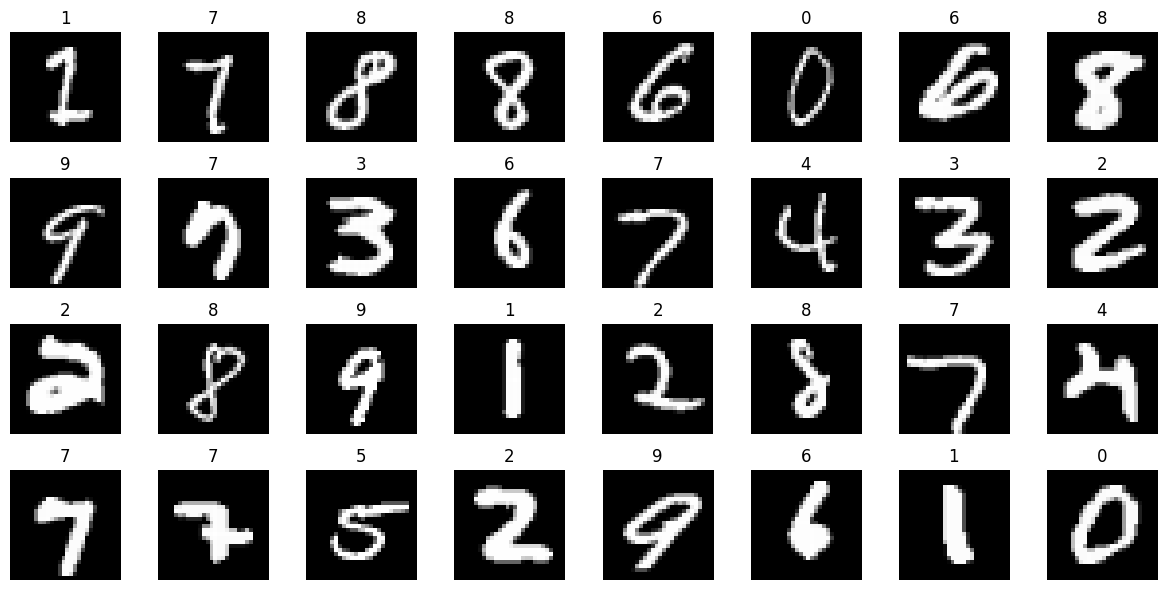

In [ ]:
images, labels = next(iter(trainloaders[0]))
print(images.shape)

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

## Model definition

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), padding='same')
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Functions for train and test

In [ ]:
def train_wo_FL(net, dataloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    net.train()

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(dataloader.dataset)
        epoch_acc = correct / total

        if verbose:
          print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


    return epoch_loss.detach().cpu().numpy(), epoch_acc


def test_wo_FL(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    preds = []
    test_data = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            preds.append(predicted.detach().cpu().numpy())
            test_data.append(labels.detach().cpu().numpy())
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy, preds, test_data

def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

## Centralized training

In [ ]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

loss_train, loss_val, acc_train, acc_val = [], [], [], []
for epoch in range(10):
  loss_t, acc_t = train_wo_FL(net, trainloader, 1)
  loss_train.append(loss_t)
  acc_train.append(acc_t)
  loss, accuracy, _, _ = test_wo_FL(net, valloader)
  loss_val.append(loss)
  acc_val.append(accuracy)

loss, accuracy, preds, test_data = test_wo_FL(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Final test set performance:
	loss 0.003914832420414314
	accuracy 0.9611


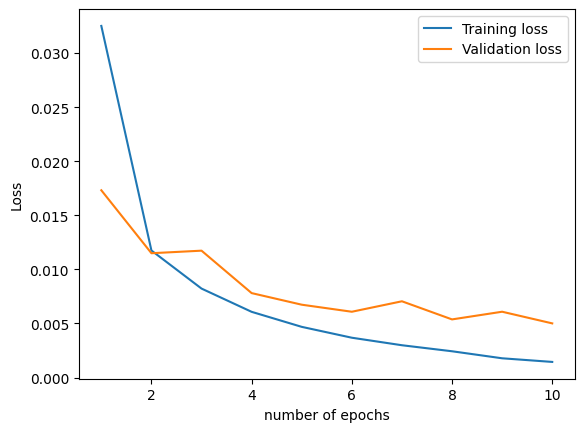

In [ ]:
plt.plot(np.arange(10)+1, loss_train)
plt.plot(np.arange(10)+1, loss_val)
plt.xlabel("number of epochs")
plt.ylabel("Loss")
plt.legend(["Training loss", "Validation loss"])
plt.show()

In [ ]:
# print(np.array(preds, dtype=object))
preds_flat = np.array([i for elements in preds for i in elements])
test_data_flat = np.array([i for elements in test_data for i in elements])

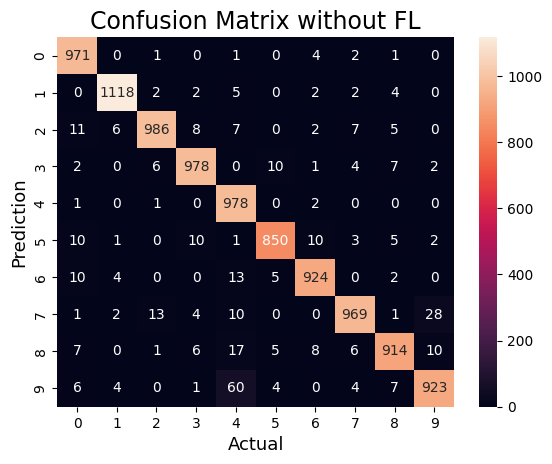

Accuracy   : 0.9611


In [ ]:
#Import the necessary libraries
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# compute the confusion matrix
cm = confusion_matrix(test_data_flat,preds_flat)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix without FL',fontsize=17)
plt.show()


# Finding precision and recall
accuracy = accuracy_score(test_data_flat, preds_flat)
print("Accuracy   :", accuracy)

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
# for param_tensor in net.state_dict():
#     print(param_tensor, "\t", net.state_dict()[param_tensor].size())
for key, value in net.state_dict().items():
  print(key, "\t", net.state_dict()[key].size())

Model's state_dict:
conv1.weight 	 torch.Size([8, 1, 3, 3])
conv1.bias 	 torch.Size([8])
conv2.weight 	 torch.Size([16, 8, 3, 3])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 784])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])


In [ ]:
print(net.state_dict().keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


In [ ]:
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
         MaxPool2d-2            [-1, 8, 14, 14]               0
            Conv2d-3           [-1, 16, 14, 14]           1,168
         MaxPool2d-4             [-1, 16, 7, 7]               0
            Linear-5                  [-1, 120]          94,200
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 106,462
Trainable params: 106,462
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.41
Estimated Total Size (MB): 0.50
----------------------------------------------------------------


## Functions to load and update model parameters

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [ ]:
params = get_parameters(net)
set_parameters(net, params)
updated_params = get_parameters(net)

## Flower Client Class definition

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=10)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

## Virtual Client function


In [ ]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (MNIST)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

## Start Training

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-05-17 02:07:59,658 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-05-17 02:08:04,600	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-05-17 02:08:08,004 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7704851252.0, 'GPU': 1.0, 'object_store_memory': 3852425625.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7704851252.0, 'GPU': 1.0, 'object_store_memory': 3852425625.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-05-17 02:08:08,014 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-05-17 02:08:08,021 | server.py:273 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
(pid=38146) 2023-05-17 02:08:15.612790

(autoscaler +20m24s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +20m24s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(pid=45861) 2023-05-17 02:27:57.952366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=46017) 2023-05-17 02:28:21.974966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=46157) 2023-05-17 02:28:45.946408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=46304) 2023-05-17 02:29:08.907935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=46436) 2023-05-17 02:29:31.457747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=46582) 2023-05-17 02:29:55.616613: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
DEBUG flwr 2023-05-17 02:30:15,383 | server.py:232 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-05-17 02:3

History (loss, distributed):
	round 1: 0.009903586876889069
	round 2: 0.0021184838007805716
	round 3: 0.0015012694125446917
	round 4: 0.001718219330606189
	round 5: 0.0011495722287748625

## Retrieve accuracy metrics

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-05-17 02:30:54,977 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-05-17 02:30:59,401	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-05-17 02:31:01,198 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 7671459840.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3835729920.0, 'CPU': 2.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7671459840.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3835729920.0, 'CPU': 2.0, 'GPU': 1.0}
INFO flwr 2023-05-17 02:31:01,208 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-05-17 02:31:01,214 | server.py:273 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
(pid=47358) 2023-05-17 02:31:03.556617

(autoscaler +23m42s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(pid=47565) 2023-05-17 02:31:32.308137: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=47698) 2023-05-17 02:31:55.240310: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=47841) 2023-05-17 02:32:17.855783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=47970) 2023-05-17 02:32:39.393516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48107) 2023-05-17 02:33:02.616314: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48236) 2023-05-17 02:33:24.026144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48369) 2023-05-17 02:33:47.950429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48510) 2023-05-17 02:34:09.261738: W tensor

(autoscaler +27m28s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(pid=48848) 2023-05-17 02:35:01.669133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48926) 2023-05-17 02:35:10.033709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48989) 2023-05-17 02:35:16.117429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49061) 2023-05-17 02:35:24.451403: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
DEBUG flwr 2023-05-17 02:35:28,514 | server.py:182 | evaluate_round 1 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2023-05-17 02:35:28,518 | server.py:218 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)
(pid=49134) 2023-05-17 02:35:31.112986: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could no

(autoscaler +28m3s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(pid=49273) 2023-05-17 02:35:54.878662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49406) 2023-05-17 02:36:16.219687: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49534) 2023-05-17 02:36:39.677872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49672) 2023-05-17 02:37:01.925466: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49806) 2023-05-17 02:37:23.480337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49944) 2023-05-17 02:37:47.422474: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=50075) 2023-05-17 02:38:08.956992: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(autoscaler +30m58s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(pid=50208) 2023-05-17 02:38:32.573113: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=50346) 2023-05-17 02:38:54.121141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
DEBUG flwr 2023-05-17 02:39:13,347 | server.py:232 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-05-17 02:39:13,377 | server.py:168 | evaluate_round 2: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 10)
(pid=50484) 2023-05-17 02:39:18.246592: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=50556) 2023-05-17 02:39:24.677720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=50619) 2023-05-17 02:39:32.554794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could no

(autoscaler +33m9s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(pid=51121) 2023-05-17 02:40:41.473744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=51255) 2023-05-17 02:41:03.757291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=51397) 2023-05-17 02:41:28.114350: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=51532) 2023-05-17 02:41:49.656423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=51670) 2023-05-17 02:42:13.986265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=51801) 2023-05-17 02:42:35.292212: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=51934) 2023-05-17 02:42:59.317139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=52076) 2023-05-17 02:43:21.440002: W tensor

(autoscaler +44m0s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(pid=55397) 2023-05-17 02:51:55.797130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=55533) 2023-05-17 02:52:17.379375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
DEBUG flwr 2023-05-17 02:52:37,052 | server.py:232 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-05-17 02:52:37,089 | server.py:168 | evaluate_round 5: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 10)
(pid=55672) 2023-05-17 02:52:41.802257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=55747) 2023-05-17 02:52:48.775966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=55813) 2023-05-17 02:52:56.456573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could no

History (loss, distributed):
	round 1: 0.005421270014097293
	round 2: 0.0018182663832885739
	round 3: 0.0019584687754387836
	round 4: 0.0014922434141468178
	round 5: 0.002486052321589076
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.9596666666666669), (2, 0.9820000000000001), (3, 0.9876666666666668), (4, 0.989), (5, 0.9876666666666667)]}